In [1]:
"""
Transformer Network Application: Extractive Question Answering
"""
import os
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForQuestionAnswering
from datasets import load_from_disk
import matplotlib.pyplot as plt

In [2]:
# DATASET
# Load the dataset previously saved to disk using Hugging Face's save_to_disk method.
ds_path = os.path.join(os.getcwd(), "data")
babi_dataset = load_from_disk(ds_path)

In [3]:
babi_dataset

DatasetDict({
    train: Dataset({
        features: ['story'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story'],
        num_rows: 1000
    })
})

In [4]:
babi_dataset['train'][0]

{'story': {'answer': ['', '', 'office'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['1']],
  'text': ['The office is north of the kitchen.',
   'The garden is south of the kitchen.',
   'What is north of the kitchen?'],
  'type': [0, 0, 1]}}

Note:
id: Represents a unique identifier for each sentence or entry in the story.

'id': ['1', '2', '3']
Sentence 1: "The bedroom is west of the office."
Sentence 2: "The bedroom is east of the hallway."
Sentence 3: "What is east of the hallway?"


supporting_ids
Refers to the IDs of other sentences or entries in the dataset that provide supporting evidence for a particular text answer.
For instance, in a question-answering task:
Supporting sentences provide context to derive the answer.
Example: 'supporting_ids': [[], [], ['2']
Sentence 1: No supporting sentences needed (empty list).
Sentence 2: No supporting sentences needed (empty list).
Sentence 3: Relies on sentence 2 ("The bedroom is east of the hallway.") to answer the question "What is east of the hallway?"


type
Indicates the category or purpose of each sentence in the dataset.
0: Declarative sentences or facts.
1: Questions or queries.
Example: 'type': [0, 0, 1]
Sentence 1: Declarative sentence (type = 0).
Sentence 2: Declarative sentence (type = 0).
Sentence 3: Question (type = 1).

In [5]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type'] ) not in type_set:
        type_set.add(str(story['story']['type'] ))

In [6]:
type_set

{'[0, 0, 1]'}

In [7]:
# Flatten the dataset to transform it from a dictionary structure to a table structure to make it easier to work with.
flattened_babi = babi_dataset.flatten()
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [8]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

In [9]:
# Extract the answer, question, and facts from the story, and join the facts into a single entry under 'sentences'.
def get_question_and_facts(story):
    """
    Processes a story to extract the question, facts, and answer. 
    All facts are joined under a single string (stored under 'sentences').
    
    Arguments:
        story (dict): A dictionary containing the story data with the following keys:
            - 'story.text' (list of str): A list where each string is a sentence in the story.
            - 'story.answer' (list of str): A list where each string is an answer corresponding to a sentence.

    Returns:
        dict: A dictionary containing:
            - 'question' (str): The question extracted from the story (last index in sentences).
            - 'sentences' (str): A single string combining all sentences of the story except the last one.
            - 'answer' (str): The answer to the extracted question.
    """

    dic = {}

    # Extract the question (assumes it is the last index of 'story.text')
    dic['question'] = story['story.text'][-1]

    # Combine the sentences into one string under 'sentences'
    dic['sentences'] = ' '.join([sentences for sentences in story['story.text'][:-1]])

    # Extract the corresponding answer for the question (assumes it is at the last index of 'story.answer')
    dic['answer'] = story['story.answer'][-1]

    return dic

In [10]:
processed = flattened_babi.map(get_question_and_facts)

In [11]:
processed['train'][0]

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the kitchen?',
 'sentences': 'The office is north of the kitchen. The garden is south of the kitchen.',
 'answer': 'office'}

In [12]:
processed['test'][0]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The hallway is east of the bathroom.',
  'The bedroom is west of the bathroom.',
  'What is the bathroom east of?'],
 'story.type': [0, 0, 1],
 'question': 'What is the bathroom east of?',
 'sentences': 'The hallway is east of the bathroom. The bedroom is west of the bathroom.',
 'answer': 'bedroom'}

The goal of extractive QA is to find the part of the text that contains the answer to the question. 
For example, if the answer to some question was 'bathroom', you would need to find the start and end 
string indices of the  word 'bathroom' in the context sentence 'The hallway is east of the bathroom. 
The bedroom is west of the bathroom.' Let's identify the position of the answer using indexes of the string. 

In [13]:
def get_start_end_idx(story):
    """
    Identifies the start and end string indices of the answer within a given context.

    This function is designed for extractive Question Answering (QA) tasks, where the goal is 
    to find the exact portion of the text that contains the answer to a given question. It works 
    by locating the starting index of the answer in the context and calculating the ending index 
    based on the answer's length.

    Args:
        story (dict): A dictionary containing:
            - 'sentences' (str): The context or passage text where the answer is located.
            - 'answer' (str): The target word or phrase to locate in the context.

    Returns:
        dict: A dictionary containing:
            - 'str_idx' (int): The starting index of the answer in the context text.
            - 'end_idx' (int): The ending index of the answer in the context text (exclusive).
    """
    
    # Find the starting index of the answer in the context string
    str_idx = story['sentences'].find(story['answer'])
    
    # Calculate the ending index based on the answer's length
    end_idx = str_idx + len(story['answer'])
    
    # Return the start and end indices as a dictionary
    return {
        'str_idx': str_idx,
        'end_idx': end_idx
    }

In [14]:
processed = processed.map(get_start_end_idx)

In [15]:
processed['test'][0]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The hallway is east of the bathroom.',
  'The bedroom is west of the bathroom.',
  'What is the bathroom east of?'],
 'story.type': [0, 0, 1],
 'question': 'What is the bathroom east of?',
 'sentences': 'The hallway is east of the bathroom. The bedroom is west of the bathroom.',
 'answer': 'bedroom',
 'str_idx': 41,
 'end_idx': 48}

In [16]:
# Testing
num = 0
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('Answer:', processed['test'][num]['sentences'][start_idx:end_idx])

Answer: bedroom


Transformer models rely on tokenizers that split words into subwords, which can cause misalignment between
dataset tags and tokenized labels. For extractive QA, it's crucial to align the start and end indices of 
the answer with the corresponding token indices using a tokenize_and_align() function. This ensures the 
character-based sentence index matches the token index for the target word.

In [17]:
# TOKENIZE AND ALIGN WITH HUGGING FACE LIBRARY
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.clean_up_tokenization_spaces = True

In [18]:
def tokenize_align(example):
    """
    Tokenizes input text and aligns character indices with token positions for extractive Question Answering.

    This function uses a pretrained tokenizer to process a context ('sentences') and a question, mapping
    the character-based start and end indices of the answer in the context to their corresponding token
    indices in the tokenized sequence.

    Arguments:
        example (dict): A dictionary containing:
            - 'sentences' (str): Context or passage text where the answer is located.
            - 'question' (str): The question to be answered based on the context.
            - 'str_idx' (int): The character index where the answer starts in the context.
            - 'end_idx' (int): The character index where the answer ends in the context.

    Returns:
        dict: A dictionary containing:
            - 'input_ids' (list of int): Token IDs of the tokenized input.
            - 'attention_mask' (list of int): Mask indicating valid tokens (1) and padding (0).
            - 'start_positions' (int): Token index corresponding to the start of the answer.
            - 'end_positions' (int): Token index corresponding to the end of the answer.
    
    Notes:
        - If the character-based start or end indices cannot be mapped to tokens, they default to the
          maximum sequence length of the tokenizer.
    """
    
    # Tokenize the input sentences and question, applying truncation and padding
    encoding = tokenizer(
        example['sentences'], 
        example['question'], 
        truncation=True, 
        padding=True, 
        max_length=tokenizer.model_max_length
    )

    # Map character indices to token indices
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx'] - 1)  # Subtract 1 to ensure inclusivity

    # Handle cases where mapping fails (e.g., special tokens or padding)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length

    # Return the processed output
    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'start_positions': start_positions,
        'end_positions': end_positions
    }


In [19]:
qa_dataset = processed.map(tokenize_align)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])
qa_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'sentences', 'answer', 'str_idx', 'end_idx', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['question', 'sentences', 'answer', 'str_idx', 'end_idx', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1000
    })
})

In [21]:
qa_dataset['train'][0]

{'question': 'What is north of the kitchen?',
 'sentences': 'The office is north of the kitchen. The garden is south of the kitchen.',
 'answer': 'office',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  2436,
  2003,
  2167,
  1997,
  1996,
  3829,
  1012,
  1996,
  3871,
  2003,
  2148,
  1997,
  1996,
  3829,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  3829,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 2,
 'end_positions': 2}

In [22]:
# TRAINING
# Helper function to create TF datasets
def create_tfdataset(data_ds, col_2_return, batch_size=8, enable_prefetch=True):
    """
    This function processes the input dataset by extracting specified columns,
    reshaping labels, and batching the data. It optionally applies prefetching
    to optimize data loading during training.
    
    Arguments:
        data_ds (datasets.Dataset): Input Hugging Face dataset.
        col_2_return (list of str): List of columns to convert to TensorFlow tensors.
        batch_size (int): Batch size for training. Default is 8.
        enable_prefetch (bool): Whether to apply prefetching. Default is True.
    
    Returns:
        tf.data.Dataset: A batched TensorFlow dataset.
    """
    # Set the format to use specified columns
    data_ds.set_format(type='tf', columns=col_2_return)
    
    # Extract features and labels from the dataset
    ds_features = {x: data_ds[x] for x in ['input_ids', 'attention_mask']}
    ds_labels = {
        y: tf.reshape(data_ds[y], shape=[-1, 1]) 
        for y in ['start_positions', 'end_positions']
    }
    
    # Create a TensorFlow dataset from features and labels
    tf_dataset = tf.data.Dataset.from_tensor_slices((ds_features, ds_labels)).batch(batch_size)
    
    # Apply optional prefetching
    if enable_prefetch:
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        tf_dataset = tf_dataset.prefetch(AUTOTUNE)
    
    return tf_dataset

In [23]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

# Create TF datasets
train_tfdataset = create_tfdataset(train_ds, col_2_return=columns_to_return)
test_tfdataset = create_tfdataset(test_ds, col_2_return=columns_to_return)

test_tfdataset.cardinality().numpy()

125

In [24]:
# No cross-validation dataset was provided. Let's create some from the test dataset
val_tfdataset = test_tfdataset.take(100)
test_tfdataset = test_tfdataset.skip(100)

print("Training batches:",train_tfdataset.cardinality().numpy())
print("CV batches:",val_tfdataset.cardinality().numpy())
print("Test batches:",test_tfdataset.cardinality().numpy())

Training batches: 125
CV batches: 100
Test batches: 25


Time to train the model.
Create a custom training function using  `tf.GradientTape()`which  records the operations 
performed during forward prop for automatic differentiation during backprop. 
We'll target two loss functions, one for the start index and one for the end index. 

In [25]:
# Define the loss functions for start and end position predictions
loss_fn1 = SparseCategoricalCrossentropy(from_logits=True)
loss_fn2 = SparseCategoricalCrossentropy(from_logits=True)


def compute_loss(y_batch, answers_start_scores, answers_end_scores, loss_func1, loss_func2):
    """
    Computes the loss for extractive Question Answering tasks.

    This function calculates the combined loss for start and end position predictions,
    given the ground truth labels and model outputs. It uses two separate loss functions
    (typically SparseCategoricalCrossentropy) to handle each prediction independently and
    averages the results to compute the final loss.

    Args:
        y_batch (dict): Contains the ground truth labels with:
            - 'start_positions' (Tensor): The true start positions of the answers.
            - 'end_positions' (Tensor): The true end positions of the answers.
        answers_start_scores (Tensor): Predicted logits for the start positions.
        answers_end_scores (Tensor): Predicted logits for the end positions.
        loss_func1: Loss function for the start positions (e.g., SparseCategoricalCrossentropy).
        loss_func2: Loss function for the end positions (e.g., SparseCategoricalCrossentropy).

    Returns:
        Tensors: 
            The average of the start and end losses, weighted equally
            The start loss
            The end loss
    """
    
    # Compute the loss for start positions
    loss_start = loss_func1(y_batch['start_positions'], answers_start_scores)
    
    # Compute the loss for end positions
    loss_end = loss_func2(y_batch['end_positions'], answers_end_scores)
    
    # Combine the losses (average the start and end losses)
    avg_loss = 0.5 * (loss_start + loss_end)
    
    return avg_loss, loss_start, loss_end

In [26]:
# Model
model = TFDistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased', return_dict=False)
# print(model.config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

In [28]:
# Define the optimizer for training
opt = Adam(learning_rate=1e-5)

EPOCHS = 30
best_val_loss = float("inf")  # Initialize th ebest validation loss
patience = 10  # Number of epochs to wait before stopping
no_improve_count = 0  # Counter for epochs without improvement

losses = []
epoch_val_losses = []
epoch_train_losses = []

for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train, training=True)
            loss, loss_s, loss_e = compute_loss(y_batch_train, answer_start_scores, answer_end_scores, loss_fn1, loss_fn2)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("  Training loss (for one batch) at step %d-----Start: %.4f  End: %.4f  Avg.: %.4f"% (step, float(loss_s), float(loss_e), float(loss)))

    epoch_train_losses.append(losses[-1])

    # Validation step
    val_loss = 0
    for vstep, (x_batch_val, y_batch_val) in enumerate(val_tfdataset):
        val_answer_start_scores, val_answer_end_scores  = model(x_batch_val, training=False)
        avg_val_loss, _, _ = compute_loss(y_batch_val, val_answer_start_scores, val_answer_end_scores, loss_fn1, loss_fn2)
        val_loss += avg_val_loss  # Accumulate validation loss
    
    val_loss /= len(val_tfdataset)
    epoch_val_losses.append(val_loss)
    print(f"  --------Validation avg. loss: {val_loss}")

    # Save the model if the validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = os.path.join(os.getcwd(), "model", f"model_weights_epoch_{epoch+1:02d}.h5")
        model.save_weights(save_path)
    else:
        no_improve_count += 1  # Increase counter if no improvement

    if no_improve_count >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break  # Stop training

Starting epoch: 0
  Training loss (for one batch) at step 0-----Start: 0.2824  End: 0.2558  Avg.: 0.2691
  Training loss (for one batch) at step 20-----Start: 0.0321  End: 0.0350  Avg.: 0.0336
  Training loss (for one batch) at step 40-----Start: 0.4785  End: 0.4627  Avg.: 0.4706
  Training loss (for one batch) at step 60-----Start: 0.2718  End: 0.2516  Avg.: 0.2617
  Training loss (for one batch) at step 80-----Start: 0.1218  End: 0.0821  Avg.: 0.1020
  Training loss (for one batch) at step 100-----Start: 0.0808  End: 0.0605  Avg.: 0.0706
  Training loss (for one batch) at step 120-----Start: 0.5816  End: 0.5227  Avg.: 0.5522
  --------Validation avg. loss: 0.31520459055900574
Starting epoch: 1
  Training loss (for one batch) at step 0-----Start: 0.2924  End: 0.2656  Avg.: 0.2790
  Training loss (for one batch) at step 20-----Start: 0.0410  End: 0.0378  Avg.: 0.0394
  Training loss (for one batch) at step 40-----Start: 0.4405  End: 0.4451  Avg.: 0.4428
  Training loss (for one batch) 

2025-05-05 20:42:09.270086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  --------Validation avg. loss: 0.34743762016296387
Starting epoch: 3
  Training loss (for one batch) at step 0-----Start: 0.2550  End: 0.2676  Avg.: 0.2613
  Training loss (for one batch) at step 20-----Start: 0.0242  End: 0.0255  Avg.: 0.0249
  Training loss (for one batch) at step 40-----Start: 0.4796  End: 0.4623  Avg.: 0.4709
  Training loss (for one batch) at step 60-----Start: 0.2416  End: 0.2598  Avg.: 0.2507
  Training loss (for one batch) at step 80-----Start: 0.0870  End: 0.0824  Avg.: 0.0847
  Training loss (for one batch) at step 100-----Start: 0.0738  End: 0.0658  Avg.: 0.0698
  Training loss (for one batch) at step 120-----Start: 0.5956  End: 0.6219  Avg.: 0.6087
  --------Validation avg. loss: 0.32761088013648987
Starting epoch: 4
  Training loss (for one batch) at step 0-----Start: 0.2171  End: 0.2413  Avg.: 0.2292
  Training loss (for one batch) at step 20-----Start: 0.0164  End: 0.0182  Avg.: 0.0173
  Training loss (for one batch) at step 40-----Start: 0.4914  End: 0

2025-05-05 21:05:31.676173: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  --------Validation avg. loss: 0.0001072858867701143
Starting epoch: 19
  Training loss (for one batch) at step 0-----Start: 0.0072  End: 0.0080  Avg.: 0.0076
  Training loss (for one batch) at step 20-----Start: 0.0002  End: 0.0002  Avg.: 0.0002
  Training loss (for one batch) at step 40-----Start: 0.0030  End: 0.0018  Avg.: 0.0024
  Training loss (for one batch) at step 60-----Start: 0.5891  End: 0.5522  Avg.: 0.5706
  Training loss (for one batch) at step 80-----Start: 0.0031  End: 0.0035  Avg.: 0.0033
  Training loss (for one batch) at step 100-----Start: 0.0004  End: 0.0005  Avg.: 0.0004
  Training loss (for one batch) at step 120-----Start: 0.0069  End: 0.0071  Avg.: 0.0070
  --------Validation avg. loss: 0.0001316112175118178
Starting epoch: 20
  Training loss (for one batch) at step 0-----Start: 0.0002  End: 0.0002  Avg.: 0.0002
  Training loss (for one batch) at step 20-----Start: 0.0002  End: 0.0003  Avg.: 0.0002
  Training loss (for one batch) at step 40-----Start: 0.0005  

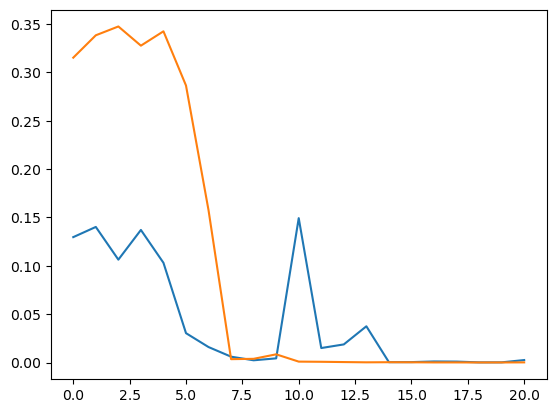

In [29]:
plt.plot(epoch_train_losses)
plt.plot(epoch_val_losses)
plt.show()

In [30]:
# PREDICT: Performing question answering on a given story
# Define the question and the story text
question = 'What is south of the bedroom?'
text = 'The hallway is south of the garden. The garden is south of the bedroom.'

# Tokenize the text and question for the model
# The tokenizer converts the input text and question into a format suitable for the model,
# creating input IDs and attention masks as tensors.
input_dict = tokenizer(text, question, return_tensors='tf')

# Perform a forward pass through the model to obtain start and end logits
# - start_logits: Scores for the start positions of the answer in the input text
# - end_logits: Scores for the end positions of the answer in the input text
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

# Decode the token IDs back into text to extract the answer
# - 'convert_ids_to_tokens' translates input IDs back to words/tokens
# print(input_dict["input_ids"].numpy().shape)  # Output: (1, 26)
all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])

# Compute the answer by finding the tokens corresponding to the start and end logits
# - 'argmax' determines the position of the maximum score for start and end logits
# - '[start:end + 1]' slices the tokens to include the full answer
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, axis=-1)[0] : tf.math.argmax(end_logits, axis=-1)[0] + 1])
print(f"Q: {question}\nA: {answer.capitalize()}")

Q: What is south of the bedroom?
A: Garden


In [31]:
def predict_answer(trained_model, the_tokenizer, the_question, the_text):
    """
    Predicts the answer to a question based on a given text using an extractive QA model.

    This function tokenizes the input text and question, performs a forward pass through
    the model to obtain start and end logits, and extracts the answer based on the token indices.

    Arguments:
        trained_model: The pretrained extractive QA model (e.g., Hugging Face model for Question Answering).
        the_tokenizer: The tokenizer corresponding to the model (e.g., DistilBERT tokenizer).
        the_question (str): The question to be answered based on the context.
        the_text (str): The context or passage text containing the answer.

    Returns:
        str: The extracted answer to the question from the text.
    """
    # Tokenize the text and question for the model
    input_dict = the_tokenizer(the_text, the_question, return_tensors='tf')

    # Perform a forward pass through the model to obtain start and end logits
    outputs = trained_model(input_dict, training=False)
    start_logits = outputs[0]  # Start positions of answer
    end_logits = outputs[1]    # End positions of answer

    # Decode token IDs back into text tokens
    all_tokens = the_tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])

    # Compute the answer by slicing tokens based on predicted start and end positions
    answer = ' '.join(all_tokens[
        tf.math.argmax(start_logits, axis=-1)[0] : tf.math.argmax(end_logits, axis=-1)[0] + 1
    ])

    return answer.capitalize()

In [32]:
# Test predict_answer()
question2 = "What is north of the museum?"
text2 = "Mum enjoys visiting the museum because our house is 5 minutes north of the museum. "
answer2 = predict_answer(model, tokenizer, question2, text2)
print(f"Q: {question2}\nA: {answer2}")

Q: What is north of the museum?
A: House


In [33]:
next(iter(test_tfdataset))

({'input_ids': <tf.Tensor: shape=(8, 26), dtype=int64, numpy=
  array([[ 101, 1996, 3829, 2003, 2167, 1997, 1996, 5723, 1012, 1996, 3829,
          2003, 2148, 1997, 1996, 2436, 1012,  102, 2054, 2003, 1996, 2436,
          2167, 1997, 1029,  102],
         [ 101, 1996, 2436, 2003, 2225, 1997, 1996, 3829, 1012, 1996, 6797,
          2003, 2264, 1997, 1996, 3829, 1012,  102, 2054, 2003, 2225, 1997,
          1996, 3829, 1029,  102],
         [ 101, 1996, 3829, 2003, 2264, 1997, 1996, 6797, 1012, 1996, 3871,
          2003, 2264, 1997, 1996, 3829, 1012,  102, 2054, 2003, 1996, 6797,
          2225, 1997, 1029,  102],
         [ 101, 1996, 5010, 2003, 2167, 1997, 1996, 2436, 1012, 1996, 3829,
          2003, 2148, 1997, 1996, 2436, 1012,  102, 2054, 2003, 2148, 1997,
          1996, 2436, 1029,  102],
         [ 101, 1996, 2436, 2003, 2148, 1997, 1996, 6797, 1012, 1996, 3829,
          2003, 2148, 1997, 1996, 2436, 1012,  102, 2054, 2003, 1996, 6797,
          2167, 1997, 1029,  102],
   

In [34]:
def predict_and_evaluate(test_tf_ds, trained_model, the_tokenizer):
    """
    Predicts answers, evaluates them against ground truths, and calculates accuracy.

    Args:
        test_tf_ds (tf.data.Dataset): The test dataset containing input features and ground truth labels.
        trained_model: The pre-trained question-answering model (e.g., DistilBERT).
        the_tokenizer: Tokenizer corresponding to the model for tokenization and decoding.

    Returns:
        float: Accuracy of the predictions on the test dataset.
    """
    correct_predictions = 0
    total_samples = 0
    predicted_answers, ground_truths = [], []

    for step, (x_batch_test, y_batch_test) in enumerate(test_tf_ds):
        # Get model outputs for the batch
        outputs = trained_model(x_batch_test, training=False)
        all_tokens = the_tokenizer.convert_ids_to_tokens(x_batch_test["input_ids"].numpy()[0])
        
        for example_idx in range(len(y_batch_test['start_positions'])):  # Batch size
            # Ground truths
            start_gt_idx = int(y_batch_test["start_positions"][example_idx].numpy()[0])
            end_gt_idx = int(y_batch_test["end_positions"][example_idx].numpy()[0])
            ground_truth = ' '.join(all_tokens[start_gt_idx:end_gt_idx + 1]) 
            ground_truths.append(ground_truth)

            # Predictions
            start_pred_idx = int(tf.math.argmax(outputs[0][example_idx], axis=-1))
            end_pred_idx = int(tf.math.argmax(outputs[1][example_idx], axis=-1))
            pred_answer = ' '.join(all_tokens[start_pred_idx : end_pred_idx + 1])
            predicted_answers.append(pred_answer)

            # Compare the predicted answer with the ground truth
            if pred_answer.strip().lower() == ground_truth.strip().lower():
                correct_predictions += 1

            total_samples += 1

    # Calculate accuracy
    ds_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    
    # Print evaluation results
    
    print(f"Total samples: {total_samples}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Model Accuracy: {correct_predictions / total_samples:.4f}")
    
    return ds_accuracy


In [35]:
test_accuracy = predict_and_evaluate(test_tfdataset, model, tokenizer)

Total samples: 200
Correct Predictions: 200
Model Accuracy: 1.0000
